# 1. Sentimentos com Spacy

In [1]:
import spacy
import pt_core_news_sm
import pandas as pd
import string
import random
import seaborn as sns
import numpy as np

In [2]:
base_dados = pd.read_excel('./data/Emocoes.xlsx',
                 error_bad_lines=False,
                  usecols = ['Frase', 'Emoção'])

In [3]:
base_dados.head()

,Frase,Emoção
0,"A alegria do pobre, ainda que menos durável, é...",alegria
1,A alegria que se tem em pensar e aprender faz-...,alegria
2,A amizade é um amor que nunca morre.,alegria
3,"A elite ficou ofendida, mas as pessoas comuns ...",raiva
4,A exasperação de Robbie encontrou vazão,raiva


In [4]:
base_dados.isnull().sum()

Frase     0
Emoção    0
dtype: int64

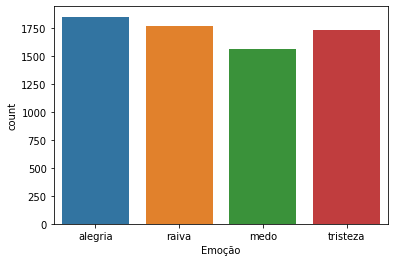

In [5]:
sns.countplot(base_dados['Emoção'], label = 'Contagem')

# Pré Processamento

In [6]:
from spacy.lang.pt.stop_words import STOP_WORDS
stop_words = STOP_WORDS
stop_words.add('o')

In [7]:
pln = spacy.load('pt_core_news_sm')

In [8]:
def preprocessamento(texto):
    texto = texto.lower()
    documento = pln(texto)
    
    lista = []
    for token in documento:
        lista.append(token.lemma_)
        
    lista = [palavra for palavra in lista if palavra not in stop_words and palavra not in string.punctuation ]
    lista = ' '.join([str(elemento) for elemento in lista if not elemento.isdigit()])
    
    return lista

In [9]:
base_dados['Frase'] = base_dados['Frase'].apply(preprocessamento)

In [10]:
base_dados.head(10)

,Frase,Emoção
0,alegria pobre durável intenso rico,alegria
1,alegria pensar e aprender faz-nos pensar e apr...,alegria
2,amizade amor morrer,alegria
3,elite ficar ofendido pessoa comum adorar,raiva
4,exasperação robbie encontrar vazão,raiva
5,expressão gary ficar ansioso,medo
6,foto diferente produto,raiva
7,jovem olhar parir trás comer coelho assustar,medo
8,mãe d ficar zangar e sentir irar,raiva
9,mulher afrontar,raiva


# Tratamento da classe

In [11]:
base_dados_final = []
i = 0
for Frase, Emoção in zip(base_dados['Frase'], base_dados['Emoção']):
    if Emoção == 'alegria':
        dic = ({'ALEGRIA':True,'TRISTEZA':False,'RAIVA':False,'MEDO':False,})
        
    elif Emoção == 'tristeza':    
        dic = ({'ALEGRIA':False,'TRISTEZA':True,'RAIVA':False,'MEDO':False,})

    elif Emoção == 'raiva':    
        dic = ({'ALEGRIA':False,'TRISTEZA':False,'RAIVA':True,'MEDO':False,})

    elif Emoção == 'Medo':    
        dic = ({'ALEGRIA':False,'TRISTEZA':False, 'RAIVA':False, 'MEDO':True,})
        
    base_dados_final.append([Frase, dic.copy()])
        

In [12]:
base_dados_final

[['alegria pobre durável intenso rico',
  {'ALEGRIA': True, 'TRISTEZA': False, 'RAIVA': False, 'MEDO': False}],
 ['alegria pensar e aprender faz-nos pensar e aprender',
  {'ALEGRIA': True, 'TRISTEZA': False, 'RAIVA': False, 'MEDO': False}],
 ['amizade amor morrer',
  {'ALEGRIA': True, 'TRISTEZA': False, 'RAIVA': False, 'MEDO': False}],
 ['elite ficar ofendido pessoa comum adorar',
  {'ALEGRIA': False, 'TRISTEZA': False, 'RAIVA': True, 'MEDO': False}],
 ['exasperação robbie encontrar vazão',
  {'ALEGRIA': False, 'TRISTEZA': False, 'RAIVA': True, 'MEDO': False}],
 ['expressão gary ficar ansioso',
  {'ALEGRIA': False, 'TRISTEZA': False, 'RAIVA': True, 'MEDO': False}],
 ['foto diferente produto',
  {'ALEGRIA': False, 'TRISTEZA': False, 'RAIVA': True, 'MEDO': False}],
 ['jovem olhar parir trás comer coelho assustar',
  {'ALEGRIA': False, 'TRISTEZA': False, 'RAIVA': True, 'MEDO': False}],
 ['mãe d ficar zangar e sentir irar',
  {'ALEGRIA': False, 'TRISTEZA': False, 'RAIVA': True, 'MEDO': Fal

# Criação do Classificador

In [13]:
modelo = spacy.blank('pt')
categorias = modelo.create_pipe('textcat')
categorias.add_label("ALEGRIA")
categorias.add_label("TRISTEZA")
categorias.add_label("RAIVA")
categorias.add_label("MEDO")
categorias.add_label("SEM RÓTULO")
modelo.add_pipe(categorias)
historico = []

In [14]:
modelo.begin_training()
for epoca in range(1000):
    random.shuffle(base_dados_final)
    losses = {}
    for batch in spacy.util.minibatch(base_dados_final, 1500):
        textos = [modelo(texto) for texto, entities in batch] #modelo tenta fazer a previão
        annotations = [{'cats': entities} for texto, entities in batch] # insere as categorias
        modelo.update(textos, annotations, losses=losses)
    
    if epoca % 100 == 0:
        print(losses)
        historico.append(losses)
        # o resultado parece que o modelo se adaptou bem com os dados, quanto menor melhor

{'textcat': 2.679508696701305e-06}
{'textcat': 5.095003219324212e-08}
{'textcat': 4.067240055860566e-08}
{'textcat': 3.842831852729489e-08}
{'textcat': 3.590621577842512e-08}
{'textcat': 3.042427643151768e-08}
{'textcat': 5.067806041481049e-08}
{'textcat': 3.887038690919553e-08}
{'textcat': 3.821854699381788e-08}
{'textcat': 3.950653670869997e-08}


In [15]:
historico_loss = []
for i in historico:
    historico_loss.append(i.get('textcat'))

In [16]:
historico_loss = np.array(historico_loss)
historico_loss

array([2.67950870e-06, 5.09500322e-08, 4.06724006e-08, 3.84283185e-08,
       3.59062158e-08, 3.04242764e-08, 5.06780604e-08, 3.88703869e-08,
       3.82185470e-08, 3.95065367e-08])

Text(0, 0.5, 'Erro')

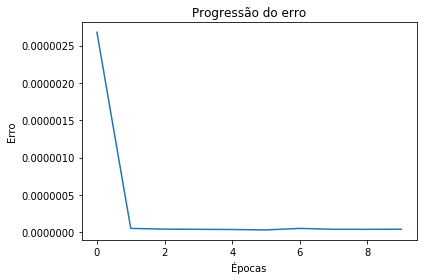

In [17]:
import matplotlib.pyplot as plt
plt.plot(historico_loss)
plt.title('Progressão do erro')
plt.xlabel('Épocas')
plt.ylabel('Erro')


## não são necessáras todas as epocas para a simulação, 

In [18]:
modelo.to_disk('modelo')

# Carregar o modelo

In [19]:
modelo_carregado = spacy.load('modelo')
modelo_carregado

In [20]:
texto_positivo = 'eu adoro cor dos seus olhos'
texto_positivo = preprocessamento(texto_positivo)
previsao = modelo_carregado(texto_positivo)
previsao.cats

{'ALEGRIA': 0.9645297527313232,
 'TRISTEZA': 0.003056093119084835,
 'RAIVA': 0.003331274027004838,
 'MEDO': 0.00021302032109815627,
 'SEM RÓTULO': 0.5}

In [21]:
texto_negativo = 'eu tenho medo dele'
texto_negativo = preprocessamento(texto_negativo)
previsao = modelo_carregado(texto_negativo)
previsao.cats

{'ALEGRIA': 0.04841597378253937,
 'TRISTEZA': 0.16320346295833588,
 'RAIVA': 0.7363989353179932,
 'MEDO': 0.0008953780634328723,
 'SEM RÓTULO': 0.5}

In [22]:
previsoes = []
for texto in base_dados['Frase']:
    #print(texto)
    previsao = modelo_carregado(texto)
    previsoes.append(previsao.cats)

In [23]:
previsoes

[{'ALEGRIA': 0.9998101592063904,
  'TRISTEZA': 4.539787187241018e-05,
  'RAIVA': 0.00010638088133418933,
  'MEDO': 4.539787187241018e-05,
  'SEM RÓTULO': 0.5},
 {'ALEGRIA': 0.9992226362228394,
  'TRISTEZA': 0.0003438881249167025,
  'RAIVA': 4.539787187241018e-05,
  'MEDO': 4.539787187241018e-05,
  'SEM RÓTULO': 0.5},
 {'ALEGRIA': 0.9975173473358154,
  'TRISTEZA': 0.0011396066984161735,
  'RAIVA': 0.0007145273266360164,
  'MEDO': 4.539787187241018e-05,
  'SEM RÓTULO': 0.5},
 {'ALEGRIA': 4.539787187241018e-05,
  'TRISTEZA': 0.00036691766581498086,
  'RAIVA': 0.9998279809951782,
  'MEDO': 4.539787187241018e-05,
  'SEM RÓTULO': 0.5},
 {'ALEGRIA': 4.539787187241018e-05,
  'TRISTEZA': 4.539787187241018e-05,
  'RAIVA': 0.9999545812606812,
  'MEDO': 4.539787187241018e-05,
  'SEM RÓTULO': 0.5},
 {'ALEGRIA': 0.0009706088458187878,
  'TRISTEZA': 4.539787187241018e-05,
  'RAIVA': 0.9985829591751099,
  'MEDO': 4.539787187241018e-05,
  'SEM RÓTULO': 0.5},
 {'ALEGRIA': 0.0005244008498266339,
  'TRIST

In [24]:
previsoes_final = []
for previsao in previsoes:
    if previsao['ALEGRIA']>previsao['MEDO'] and previsao['ALEGRIA']>previsao['RAIVA'] and previsao['ALEGRIA']>previsao['TRISTEZA']:
        previsoes_final.append('alegria')
    elif previsao['TRISTEZA']>previsao['MEDO'] and previsao['TRISTEZA']>previsao['RAIVA'] and previsao['TRISTEZA']>previsao['ALEGRIA']:
        previsoes_final.append('tristeza')
    elif previsao['MEDO']>previsao['TRISTEZA'] and previsao['MEDO']>previsao['RAIVA'] and previsao['MEDO']>previsao['ALEGRIA']:
        previsoes_final.append('medo')
    elif previsao['RAIVA']>previsao['TRISTEZA']  and previsao['RAIVA']>previsao['ALEGRIA']  and previsao['RAIVA']>previsao['MEDO']:
        previsoes_final.append('raiva')
    else:
        previsoes_final.append('sem rótulo')

previsoes_final = np.array(previsoes_final)
    

In [25]:
previsoes_final

array(['alegria', 'alegria', 'alegria', ..., 'tristeza', 'tristeza',
       'tristeza'], dtype='<U10')

In [26]:
respostas_reais = base_dados['Emoção'].values
respostas_reais

array(['alegria', 'alegria', 'alegria', ..., 'tristeza', 'medo',
       'tristeza'], dtype=object)

In [27]:
from sklearn.metrics import confusion_matrix, accuracy_score
accuracy_score(respostas_reais, previsoes_final) #se der 100 temos overfit, a base se adaptou demais 

0.7691973969631236

In [28]:
cn = confusion_matrix(respostas_reais, previsoes_final)
cn

array([[1850,    0,    1,    0,    2],
       [ 268,    0,  928,    0,  368],
       [   1,    0, 1760,    2,    3],
       [   0,    0,    0,    0,    0],
       [  11,    0,   11,    1, 1709]], dtype=int64)